In [1]:
# Importing modules
import torch as to
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch.utils.data as to_data
import datetime as datetime
from torch.utils.tensorboard import SummaryWriter as sumwriter
import os as os

In [2]:
# Specify hardware for ML training (GPU default)
device = "cuda" if to.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Quickly generate list of strings for frequency numbers and ratios
def freq_name(no_freq, include_freq=True, include_ratio=True):
    """
    Creates an ordered list of string from inputted parameters:

    no_freq = (int) number of desired frequencies
    include_freq = (bool) include the individual frequencies or not (default True)
    include_ratio = (bool) include the non-trivial ratios between frequencies or not (default True)
    """
    names = []
    if include_freq:
        for i in range(no_freq):
            names.append('f'+str(i+1))
    if include_ratio:
        for i in range(no_freq):
            for j in range(i):
                names.append('f'+str(i+1)+'/f'+str(j+1))
    return names

def get_modecols(mode_num, divs=8):
    names = []
    for i in range(81):
        names.append('m'+str(mode_num)+'_'+str(i+1))
    names = np.array(names).reshape((9,9))
    it = int(8/divs)
    return list(names[::it, ::it].flatten())

In [4]:
# Create Pytorch dataset class for data batching during training
# class FFNN_data(to_data.Dataset):
#     def __init__(self, scaled_dataframe, X_names, Y_names):
#         self.len = len(scaled_dataframe)
#         self.X = to.from_numpy(scaled_dataframe[X_names].to_numpy().astype('float32')).to(device)
#         self.Y = to.from_numpy(scaled_dataframe[Y_names].to_numpy().astype('float32')).to(device)

#     def __len__(self):
#         return self.len
  
#     def __getitem__(self, idx):
#         X_idx = self.X[idx,:]
#         Y_idx = self.Y[idx,:]
#         return X_idx, Y_idx

class FFNN_data(to_data.Dataset):
    def __init__(self, X_array, Y_array):
        self.len = X_array.shape[0]
        self.X = to.from_numpy(X_array.astype('float32')).to(device)
        self.Y = to.from_numpy(Y_array.astype('float32')).to(device)

    def __len__(self):
        return self.len
  
    def __getitem__(self, idx):
        X_idx = self.X[idx,:]
        Y_idx = self.Y[idx,:]
        return X_idx, Y_idx

In [5]:
# Creates function that returns desired activation function
def activation(activ_name):
    if activ_name=='relu':
        return to.nn.ReLU()
    elif activ_name=='lrelu':
        return to.nn.LeakyReLU()
    elif activ_name=='prelu':
        return to.nn.PReLU()
    elif activ_name=='relu6':
        return to.nn.ReLU6()
    elif activ_name=='sigmoid':
        return to.nn.Sigmoid()
    elif activ_name=='tanh':
        return to.nn.Tanh()
    elif activ_name=='silu':
        return to.nn.SiLU()
    elif activ_name=='selu':
        return to.nn.SELU()
    elif activ_name=='celu':
        return to.nn.CELU()
    elif activ_name=='gelu':
        return to.nn.GELU()
    else:
        return to.nn.ReLU()

In [6]:
class FF_Network(to.nn.Module):
    def __init__(self, num_X, num_Y, h_nodes, hactiv_type):
        super(FF_Network, self).__init__()

        self.feedfoward = []
        self.feedfoward.append(to.nn.Linear(num_X, h_nodes[0]))
        self.feedfoward.append(activation(hactiv_type))

        for i in range(len(h_nodes)-1):
            self.feedfoward.append(to.nn.Linear(h_nodes[i], h_nodes[i+1]))
            self.feedfoward.append(activation(hactiv_type))

        self.feedfoward.append(to.nn.Linear(h_nodes[-1], num_Y))

        self.feedfoward = to.nn.Sequential(*self.feedfoward).to(device)
        for i in self.feedfoward[::2]:
            to.nn.init.kaiming_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

    def forward(self, X):
        Y = self.feedfoward(X)
        return Y

In [7]:
def train_epoch(
    network,
    train_dataloader,
    loss_function, optimizer,
    tb_writer, epoch_ind
    ):

    loss_list = []
    MAPE_list = []

    for i, data in enumerate(train_dataloader):
        X, Y = data

        if epoch_ind==0 and i==0:
            tb_writer.add_graph(network, X, verbose=False)

        optimizer.zero_grad()
        predictY = network(X)

        loss = loss_function(predictY, Y)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        MAPE = to.mean(to.abs((Y - predictY) / Y)*100)
        MAPE_list.append(MAPE.item())

    
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()
    mean_MAPE = to.mean(to.tensor(MAPE_list, device=device)).item()

    return mean_loss, mean_MAPE

def valid_epoch(
    network,
    valid_dataloader,
    loss_function
    ):

    loss_list = []
    MAPE_list = []

    for i, data in enumerate(valid_dataloader):
        X, Y = data
        predictY = network(X)

        loss = loss_function(predictY, Y)
        loss_list.append(loss.item())
 
        MAPE = to.mean(to.abs((Y - predictY) / Y)*100)
        MAPE_list.append(MAPE.item())
    
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()
    mean_MAPE = to.mean(to.tensor(MAPE_list, device=device)).item()
    return mean_loss, mean_MAPE

In [8]:
def train_FFNN(
    network,
    train_dataloader, valid_dataloader,
    loss_function, optimizer_type,
    epochs, learn_rate
    ):

    if optimizer_type=='adam':
        optimizer = to.optim.Adam(network.parameters(), lr=learn_rate)
    else:
        optimizer = to.optim.SGD(network.parameters(), lr=learn_rate)
    
    tb_writer = sumwriter('Current_ML_Results/Tensorboard/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    for i in range(epochs):
        network.train(True)
        mloss, mMAPE = train_epoch(network, train_dataloader, loss_function, optimizer, tb_writer, i)

        network.eval()
        with to.no_grad():
            vmloss, vmMAPE = valid_epoch(network, valid_dataloader, loss_function)
        

        print('-'*50)
        print('Epoch {} / {}'.format(i+1,epochs))
        print('-'*15)
        print('Average Train Loss : {}'.format(mloss))
        print('Average Validation Loss : {}'.format(vmloss))

        tb_writer.add_scalars("Batch Mean Loss",
                            {
                                'Train' : mloss,
                                'Validation' : vmloss
                            }, i+1)

        # tb_writer.add_scalars("Batch MAPE",
        #                     {
        #                         'Train' : mMAPE,
        #                         'Validation' : vmMAPE
        #                     }, i+1)

    tb_writer.flush()
    tb_writer.close()

In [9]:
# Prepare Data
import sklearn.preprocessing as sk_preproc
data = pd.read_csv('Data Workspace/FS_TV.csv')
num_freq = 8

features =  freq_name(num_freq,1,1)
labels = ['nu', 'a/b', 'a/h', 'b/h', 'Q2', 'Q3', 'Q4', 'c1/a', 'c1/b']

train_split = 35000
valid_split = 7500

scaled_data = data[features+labels].copy()
scalerX = sk_preproc.StandardScaler()
scalerY = sk_preproc.StandardScaler()

scaled_data[freq_name(num_freq,1,0)] = scaled_data[freq_name(num_freq,1,0)] * (1 + (np.random.randint(0,2,scaled_data[freq_name(num_freq,1,0)].shape)*2-1)*np.random.normal(5/100, 5/100,scaled_data[freq_name(num_freq,1,0)].shape))
for x in range(num_freq):
    y = x+1
    for k in range(y-1):
        l = k+1
        ratio_str = 'f'+str(y)+'/f'+str(l)
        scaled_data[ratio_str] = scaled_data['f'+str(y)] /data['f'+str(l)]

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])
scalerX.fit(scaled_data[features])
scalerY.fit(scaled_data[labels])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
train_set, valid_set = to_data.random_split(scaled_data, [train_split, valid_split])

In [10]:
# Train Model
# Parameters
num_X = len(features)
num_Y = len(labels)
h_nodes = [60,55,50,45,40,35,30,25,20,15]
hactiv = 'silu'

batch_size_train = 100
batch_size_valid = 2000

epochs = 150
learn_rate = 1e-3

# Optim Selections
loss_function = to.nn.SmoothL1Loss()
optimizer_type = 'adam'

# Data loaders
train_loader = to.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader = to.utils.data.DataLoader(valid_set, batch_size=batch_size_valid, shuffle=True)

# Model
model = FF_Network(num_X, num_Y, h_nodes, hactiv)

In [11]:
# Train
train_FFNN(
    model,
    train_loader, valid_loader,
    loss_function, optimizer_type,
    epochs, learn_rate)

to.save(model.state_dict(), 'Current_ML_Results/model.state')

--------------------------------------------------
Epoch 1 / 150
---------------
Average Train Loss : 0.1507401317358017
Average Validation Loss : 0.08528842031955719
--------------------------------------------------
Epoch 2 / 150
---------------
Average Train Loss : 0.07923229783773422
Average Validation Loss : 0.076496921479702
--------------------------------------------------
Epoch 3 / 150
---------------
Average Train Loss : 0.06834258884191513
Average Validation Loss : 0.061186548322439194
--------------------------------------------------
Epoch 4 / 150
---------------
Average Train Loss : 0.05346061289310455
Average Validation Loss : 0.050131723284721375
--------------------------------------------------
Epoch 5 / 150
---------------
Average Train Loss : 0.04774409160017967
Average Validation Loss : 0.04600193351507187
--------------------------------------------------
Epoch 6 / 150
---------------
Average Train Loss : 0.04477812722325325
Average Validation Loss : 0.04680104926

In [12]:
# model.load_state_dict(to.load('Current_ML_Results\S_FFNN_final_model.state'))

In [13]:
# Predict FS TV Data
data = pd.read_csv('Data Workspace/FS_TV.csv')
scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

FS_TV_X = X.to('cpu')
FS_TV_Y = Y.to('cpu')
FS_TV_predictY = predictY.to('cpu')

FS_TV_error = abs_perc_error.to('cpu')
FS_TV_error_mean = MAPE_per_dim.to('cpu')
FS_TV_error_std = SDAPE_per_dim.to('cpu')

###########################################
# Predict FS Te Data
data = pd.read_csv('Data Workspace/FS_Te.csv')
scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

FS_Te_X = X.to('cpu')
FS_Te_Y = Y.to('cpu')
FS_Te_predictY = predictY.to('cpu')

FS_Te_error = abs_perc_error.to('cpu')
FS_Te_error_mean = MAPE_per_dim.to('cpu')
FS_Te_error_std = SDAPE_per_dim.to('cpu')

###########################################
# Predict RS TV Data
data = pd.read_csv('Data Workspace/RS_TV.csv')
scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

RS_TV_X = X.to('cpu')
RS_TV_Y = Y.to('cpu')
RS_TV_predictY = predictY.to('cpu')

RS_TV_error = abs_perc_error.to('cpu')
RS_TV_error_mean = MAPE_per_dim.to('cpu')
RS_TV_error_std = SDAPE_per_dim.to('cpu')

###########################################
# Predict RS Te Data
data = pd.read_csv('Data Workspace/RS_Te.csv')
scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

RS_Te_X = X.to('cpu')
RS_Te_Y = Y.to('cpu')
RS_Te_predictY = predictY.to('cpu')

RS_Te_error = abs_perc_error.to('cpu')
RS_Te_error_mean = MAPE_per_dim.to('cpu')
RS_Te_error_std = SDAPE_per_dim.to('cpu')


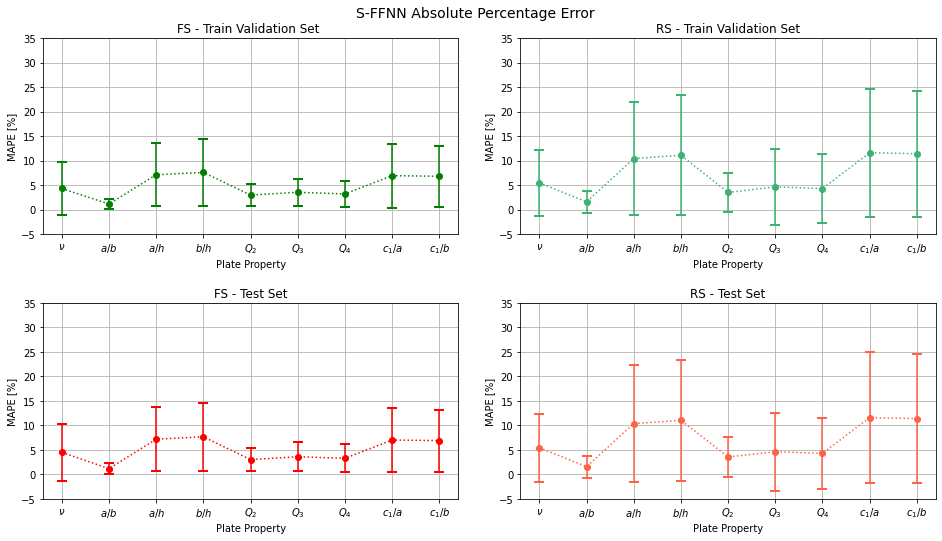

In [14]:
plot_labels = [r'$\nu$', r'$a/b$', r'$a/h$', r'$b/h$', r'$Q_2$', r'$Q_3$', r'$Q_4$', r'$c_1/a$', r'$c_1/b$']

# Error Plot
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(16,8))
ax1.errorbar(plot_labels, FS_TV_error_mean, FS_TV_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='green')
ax2.errorbar(plot_labels, FS_Te_error_mean, FS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='red')

ax3.errorbar(plot_labels, RS_TV_error_mean, RS_TV_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='mediumseagreen')
ax4.errorbar(plot_labels, RS_Te_error_mean, RS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='tomato')

ax1.set_ylim(-5,35)
ax2.set_ylim(-5,35)
ax3.set_ylim(-5,35)
ax4.set_ylim(-5,35)

ax1.set_ylabel('MAPE [%]')
ax2.set_ylabel('MAPE [%]')
ax3.set_ylabel('MAPE [%]')
ax4.set_ylabel('MAPE [%]')

ax1.set_xlabel('Plate Property')
ax2.set_xlabel('Plate Property')
ax3.set_xlabel('Plate Property')
ax4.set_xlabel('Plate Property')

ax1.set_title('FS - Train Validation Set ')
ax2.set_title('FS - Test Set')
ax3.set_title('RS - Train Validation Set')
ax4.set_title('RS - Test Set')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

fig.suptitle('S-FFNN Absolute Percentage Error', fontsize=14)
plt.subplots_adjust(wspace=0.15, hspace=0.35, top=0.925)

plt.savefig('S_FFNN_error_plot.pdf',dpi=1200, bbox_inches='tight')
plt.show()

In [15]:
df_arr = to.stack((FS_TV_error_mean, FS_TV_error_std, FS_Te_error_mean, FS_Te_error_std, RS_TV_error_mean, RS_TV_error_std, RS_Te_error_mean, RS_Te_error_std ),axis=0)
perf_df = pd.DataFrame(df_arr, columns=labels, index=['FS TV MAPE', 'FS TV SDAPE', 'FS Te MAPE', 'FS Te SDAPE', 'RS TV MAPE', 'RS TV SDAPE', 'RS Te MAPE', 'RS Te SDAPE',])
perf_df.to_excel('performance.xlsx')

In [16]:
perf_df

,nu,a/b,a/h,b/h,Q2,Q3,Q4,c1/a,c1/b
FS TV MAPE,4.342070,1.174272,7.153736,7.621831,3.004916,3.559428,3.237481,6.958819,6.833119
FS TV SDAPE,5.492624,1.080555,6.423815,6.856258,2.211225,2.805035,2.731907,6.498789,6.224809
FS Te MAPE,4.516578,1.196488,7.202018,7.682701,3.031508,3.619985,3.300656,7.028629,6.911643
FS Te SDAPE,5.744519,1.103612,6.497174,6.925254,2.341376,2.956697,2.870681,6.615839,6.311143
RS TV MAPE,5.487281,1.615551,10.447898,11.117207,3.526703,4.669190,4.326822,11.632629,11.436735
RS TV SDAPE,6.795152,2.235379,11.595651,12.216842,3.899415,7.732041,6.960605,13.038216,12.850604
RS Te MAPE,5.449303,1.601189,10.389290,11.040490,3.583306,4.633408,4.305861,11.609360,11.407006
RS Te SDAPE,6.937029,2.268217,11.855520,12.363283,4.108009,7.918165,7.180219,13.282196,13.135407


In [17]:
# Predict Simulation Data of Experimental Plates
data = pd.read_csv('Data Workspace/Experimental_Data.csv')
sfreq_list = ['sf1','sf2','sf3','sf4','sf5','sf6','sf7','sf8','sf9','sf10']
sfreq_list = ['sf1','sf2','sf3','sf4','sf5']
data[freq_name(num_freq,1,0)] = data[sfreq_list]
for x in range(num_freq):
    y = x+1
    for k in range(y-1):
        l = k+1
        ratio_str = 'f'+str(y)+'/f'+str(l)
        data[ratio_str] = data['f'+str(y)] /data['f'+str(l)]

scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

Exp_sim_X = X.to('cpu')
Exp_sim_Y = Y.to('cpu')
Exp_sim_predictY = predictY.to('cpu')

Exp_sim_error = abs_perc_error.to('cpu')
Exp_sim_error_mean = MAPE_per_dim.to('cpu')
Exp_sim_error_std = SDAPE_per_dim.to('cpu')

ValueError: Columns must be same length as key

In [ ]:
exp_df = pd.DataFrame(Exp_sim_error, columns = labels, index = ['Al-1','Al-2','Al-3','Al-4','Al-5','Al-6','St-1','St-2','St-3','St-4','St-5','St-6'])
exp_df.to_excel('exp_sim_performance.xlsx', index=1)
exp_df

In [ ]:
print(FS_Te_error_mean.mean())
print(RS_Te_error_mean.mean())
print(exp_df.mean().mean())

In [ ]:
plt.figure(figsize=(8,4))
plt.errorbar(plot_labels, exp_df.mean(), exp_df.std(), marker='o', linestyle=':', capsize=5, capthick=2, color='blue')

plt.ylim(-5,20)
plt.ylabel('MAPE [%]')
plt.xlabel('Plate Property')
plt.title('FS - Train Validation Set ')
plt.grid()
plt.title('S-FFNN Error - Simulated Experimental Plates')
plt.savefig('S_FFNN_error_plot_exp_sim.pdf',dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
LC_train = pd.read_csv("Current_ML_Results_Tensorboard_Batch Mean Loss_Train.csv")
LC_valid = pd.read_csv("Current_ML_Results_Tensorboard_Batch Mean Loss_Validation.csv")

plt.figure(figsize=(5,3.5))
plt.semilogy(LC_train['Step'], LC_train['Value'])
plt.semilogy(LC_valid['Step'], LC_valid['Value'])
plt.title('S-FFNN Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(axis='y', which='both')
plt.xlim(-1,epochs+1)
plt.ylim(0.005,0.2)
# plt.yticks([0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3],[0.1,'',0.15,'',0.2,'',0.25,'',0.3])
plt.savefig('S_FFNN_loss_curve.pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

prop_name = plot_labels[0]
axes[0,0].set_title(prop_name)
axes[0,0].set_ylabel('Predicted '+ prop_name)
axes[0,0].set_xlabel('True '+ prop_name)
axes[0,0].scatter(FS_Te_Y[:,0], FS_Te_predictY[:,0], s=1, color='salmon')
axes[0,0].plot(np.linspace(FS_Te_Y[:,0].min(),FS_Te_Y[:,0].max(), 100),np.linspace(FS_Te_Y[:,0].min(),FS_Te_Y[:,0].max(), 100), 'k--')


prop_name = plot_labels[7]
axes[1,0].set_title(prop_name)
axes[1,0].set_ylabel('Predicted  '+ prop_name)
axes[1,0].set_xlabel('True '+ prop_name)
axes[1,0].scatter(FS_Te_Y[:,7], FS_Te_predictY[:,7], s=1, color='salmon')
axes[1,0].plot(np.linspace(FS_Te_Y[:,7].min(),FS_Te_Y[:,7].max(), 100),np.linspace(FS_Te_Y[:,7].min(),FS_Te_Y[:,7].max(), 100), 'k--')
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')


prop_name = plot_labels[8]
axes[2,0].set_title(prop_name)
axes[2,0].set_ylabel('Predicted '+ prop_name)
axes[2,0].set_xlabel('True '+ prop_name)
axes[2,0].scatter(FS_Te_Y[:,8], FS_Te_predictY[:,8], s=1, color='salmon')
axes[2,0].plot(np.linspace(FS_Te_Y[:,8].min(),FS_Te_Y[:,8].max(), 100),np.linspace(FS_Te_Y[:,8].min(),FS_Te_Y[:,8].max(), 100), 'k--')
axes[2,0].set_xscale('log')
axes[2,0].set_yscale('log')


prop_name = plot_labels[1]
axes[0,1].set_title(prop_name)
axes[0,1].set_ylabel('Predicted '+ prop_name)
axes[0,1].set_xlabel('True '+ prop_name)
axes[0,1].scatter(FS_Te_Y[:,1], FS_Te_predictY[:,1], s=1, color='salmon')
axes[0,1].plot(np.linspace(FS_Te_Y[:,1].min(),FS_Te_Y[:,1].max(), 100),np.linspace(FS_Te_Y[:,1].min(),FS_Te_Y[:,1].max(), 100), 'k--')
axes[0,1].set_yticks([1,1.5,2,2.5,3,3.5,4],[1,1.5,2,2.5,3,3.5,4])


prop_name = plot_labels[2]
axes[1,1].set_title(prop_name)
axes[1,1].set_ylabel('Predicted '+ prop_name)
axes[1,1].set_xlabel('True '+ prop_name)
axes[1,1].scatter(FS_Te_Y[:,2], FS_Te_predictY[:,2], s=1, color='salmon')
axes[1,1].plot(np.linspace(FS_Te_Y[:,2].min(),FS_Te_Y[:,2].max(), 100),np.linspace(FS_Te_Y[:,2].min(),FS_Te_Y[:,2].max(), 100), 'k--')


prop_name = plot_labels[3]
axes[2,1].set_title(prop_name)
axes[2,1].set_ylabel('Predicted '+ prop_name)
axes[2,1].set_xlabel('True '+ prop_name)
axes[2,1].scatter(FS_Te_Y[:,3], FS_Te_predictY[:,3], s=1, color='salmon')
axes[2,1].plot(np.linspace(FS_Te_Y[:,3].min(),FS_Te_Y[:,3].max(), 100),np.linspace(FS_Te_Y[:,3].min(),FS_Te_Y[:,3].max(), 100), 'k--')


prop_name = plot_labels[4]
axes[0,2].set_title(prop_name)
axes[0,2].set_ylabel('Predicted '+ prop_name)
axes[0,2].set_xlabel('True '+ prop_name)
axes[0,2].scatter(FS_Te_Y[:,4], FS_Te_predictY[:,4], s=1, color='salmon')
axes[0,2].plot(np.linspace(FS_Te_Y[:,4].min(),FS_Te_Y[:,4].max(), 100),np.linspace(FS_Te_Y[:,4].min(),FS_Te_Y[:,4].max(), 100), 'k--')
axes[0,2].set_xscale('log')
axes[0,2].set_yscale('log')


prop_name = plot_labels[5]
axes[1,2].set_title(prop_name)
axes[1,2].set_ylabel('Predicted '+ prop_name)
axes[1,2].set_xlabel('True '+ prop_name)
axes[1,2].scatter(FS_Te_Y[:,5], FS_Te_predictY[:,5], s=1, color='salmon')
axes[1,2].plot(np.linspace(FS_Te_Y[:,5].min(),FS_Te_Y[:,5].max(), 100),np.linspace(FS_Te_Y[:,5].min(),FS_Te_Y[:,5].max(), 100), 'k--')
axes[1,2].set_xscale('log')
axes[1,2].set_yscale('log')


prop_name = plot_labels[6]
axes[2,2].set_title(prop_name)
axes[2,2].set_ylabel('Predicted '+ prop_name)
axes[2,2].set_xlabel('True '+ prop_name)
axes[2,2].scatter(FS_Te_Y[:,6], FS_Te_predictY[:,6], s=1, color='salmon')
axes[2,2].plot(np.linspace(FS_Te_Y[:,6].min(),FS_Te_Y[:,6].max(), 100),np.linspace(FS_Te_Y[:,6].min(),FS_Te_Y[:,6].max(), 100), 'k--')
axes[2,2].set_xscale('log')
axes[2,2].set_yscale('log')

fig.subplots_adjust(hspace=0.425, wspace=0.425, top=0.925)
fig.suptitle('S-FFNN Predictions vs True Properties',fontsize=14)
plt.savefig('S_FFNN_predict_true.pdf',dpi=1200,bbox_inches='tight')
plt.show()

In [ ]:
# plt.figure(figsize=(8,4))
# plt.errorbar(plot_labels, exp_df.mean(), exp_df.std(), marker='o', linestyle=':', capsize=5, capthick=2, color='blue')
# plt.ylim(-5,50)
# plt.ylabel('MAPE [%]')
# plt.xlabel('Plate Property')
# plt.grid()
# plt.title('S-FFNN 5 Frequency Error - Simulated Experimental Plates')
# plt.savefig('5freq_S_FFNN_error_plot_exp_sim.pdf',dpi=1200, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(8,4))
# plt.errorbar(plot_labels, RS_Te_error_mean, RS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='green')
# plt.ylim(-5,50)
# plt.ylabel('MAPE [%]')
# plt.xlabel('Plate Property')
# plt.grid()
# plt.title('S-FFNN 5 Frequency Error - RS Test Set')
# plt.savefig('5freq_S_FFNN_error_plot_RS.pdf',dpi=1200, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(8,4))
# plt.errorbar(plot_labels, FS_Te_error_mean, FS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='red')
# plt.ylim(-5,50)
# plt.ylabel('MAPE [%]')
# plt.xlabel('Plate Property')
# plt.grid()
# plt.title('S-FFNN 5 Frequency Error - FS Test Set')
# plt.savefig('5freq_S_FFNN_error_plot_FS.pdf',dpi=1200, bbox_inches='tight')
# plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.errorbar(plot_labels, exp_df.mean(), exp_df.std(), marker='o', linestyle=':', capsize=5, capthick=2, color='blue')
plt.ylim(-5,50)
plt.ylabel('MAPE [%]')
plt.xlabel('Plate Property')
plt.grid()
plt.title('S-FFNN 8 Frequency Error - Simulated Experimental Plates')
plt.savefig('8freq_S_FFNN_error_plot_exp_sim.pdf',dpi=1200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,4))
plt.errorbar(plot_labels, RS_Te_error_mean, RS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='green')
plt.ylim(-5,50)
plt.ylabel('MAPE [%]')
plt.xlabel('Plate Property')
plt.grid()
plt.title('S-FFNN 8 Frequency Error - RS Test Set')
plt.savefig('8freq_S_FFNN_error_plot_RS.pdf',dpi=1200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,4))
plt.errorbar(plot_labels, FS_Te_error_mean, FS_Te_error_std, marker='o', linestyle=':', capsize=5, capthick=2, color='red')
plt.ylim(-5,50)
plt.ylabel('MAPE [%]')
plt.xlabel('Plate Property')
plt.grid()
plt.title('S-FFNN 8 Frequency Error - FS Test Set')
plt.savefig('8freq_S_FFNN_error_plot_FS.pdf',dpi=1200, bbox_inches='tight')
plt.show()

In [18]:
# Predict Simulation Data of Experimental Plates
data = pd.read_csv('Data Workspace/Experimental_Data_Freq8.csv')

sfreq_list = ['ef1','ef2','ef3','ef4','ef5', 'ef6', 'ef7', 'ef8']
data[freq_name(num_freq,1,0)] = data[sfreq_list]
for x in range(num_freq):
    y = x+1
    for k in range(y-1):
        l = k+1
        ratio_str = 'f'+str(y)+'/f'+str(l)
        data[ratio_str] = data['f'+str(y)] /data['f'+str(l)]

scaled_data = data[features+labels].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[labels[-5:]] = np.log(scaled_data[labels[-5:]])

scaled_data = FFNN_data(scalerX.transform(scaled_data[features]), scalerY.transform(scaled_data[labels]))
data_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(data_loader):
        X, Y = data
        predictY = model.feedfoward(X)

        X = scalerX.inverse_transform(X.to('cpu'))
        Y = scalerY.inverse_transform(Y.to('cpu'))
        predictY = scalerY.inverse_transform(predictY.to('cpu'))

        X = to.from_numpy(X).to(device)
        Y = to.from_numpy(Y).to(device)
        predictY = to.from_numpy(predictY).to(device)

        Y[:,-5:] = to.exp(Y[:,-5:])
        predictY[:,-5:] = to.exp(predictY[:,-5:])
            
        abs_perc_error = to.abs((Y- predictY)/Y)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)
        SDAPE_per_dim = to.std(abs_perc_error, 0)

Exp_sim_X = X.to('cpu')
Exp_sim_Y = Y.to('cpu')
Exp_sim_predictY = predictY.to('cpu')

Exp_sim_error = abs_perc_error.to('cpu')
Exp_sim_error_mean = MAPE_per_dim.to('cpu')
Exp_sim_error_std = SDAPE_per_dim.to('cpu')

In [19]:
exp_df8 = pd.DataFrame(Exp_sim_error, columns = labels, index = ['Al-1','Al-2','Al-3','Al-4','Al-5','Al-6','St-1','St-2','St-3','St-4','St-5','St-6'])
exp_df8.to_excel('exp_sim_performance_freq8.xlsx', index=1)
exp_df8.iloc[[0,5,6,7,8,9,10,11]]

,nu,a/b,a/h,b/h,Q2,Q3,Q4,c1/a,c1/b
Al-1,20.646171,0.890614,12.755469,13.076222,1.624898,2.074255,1.395005,19.972154,19.421872
Al-6,23.252112,4.906089,47.036879,43.364885,2.406092,3.892167,5.479685,40.556097,43.495968
St-1,28.710498,1.829914,45.814681,46.392303,1.468373,2.012057,2.847097,45.013129,44.776568
St-2,39.379391,20.385942,33.402575,42.143976,25.494351,2.409342,10.927091,50.613493,41.848377
St-3,27.988087,0.002425,60.695318,59.213750,1.816170,0.923561,2.401531,57.905986,58.567550
St-4,35.721330,13.591640,43.514023,49.047431,14.817497,6.754734,3.856220,51.734148,45.686497
St-5,31.478369,0.276952,40.632496,40.233151,0.568956,1.601227,0.964577,40.950599,41.076447
St-6,38.235003,10.189729,50.464418,53.790812,8.804615,7.919464,1.247950,54.481024,50.123512


In [21]:
exp_df8.iloc[[0,5,6,7,8,9,10,11]].to_csv('8freq_perf.csv')

In [20]:
exp_df8.iloc[[0,5,6,7,8,9,10,11]].mean()

nu      30.676370
a/b      6.509163
a/h     41.789482
b/h     43.407816
Q2       7.125119
Q3       3.448351
Q4       3.639894
c1/a    45.153329
c1/b    43.124599
dtype: float64

In [ ]:
# 8 model
# AL 2 3 4 5